This example demonstrates video classification. It is an important use-case with applications in surveillance, security, and so on. We will be using the [UCF101 dataset](https://www.crcv.ucf.edu/data/UCF101.php) to build our video classifier. The dataset consists of videos categorized into different actions like cricket shot, punching, biking, etc. This is why the dataset is known to build action recognizers which is just an extension of video classification.

A video is made of an ordered sequence of frames. While the frames constitue **spatiality** the sequence of those frames constitute the **temporality** of a video. To systematically model both of these aspects we generally use a hybrid architecture that consists of convolutions (for spatiality) as well as recurrent layers (for temporality). In this example, we will be using such a hybrid architecture consisting of a Convolutional Neural Network (CNN) and a Recurrent Neural Network (RNN) consisting of [GRU layers](https://keras.io/api/layers/recurrent_layers/gru/). These kinds of hybrid architectures are popularly known as **CNN-RNN**.

This example requires TensorFlow 2.4 or higher, as well as TensorFlow Docs, which can be installed using the following command:

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


## Data collection

In order to keep the runtime of this example relatively short, we will be using a subsampled version of the original UCF101 dataset. You can refer to [this notebook](https://github.com/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Data_Preparation_UCF101.ipynb) to know how the subsampling was done.

In [ ]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

## Setup

In [ ]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

## Define hyperparameters

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

## Data preparation

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 594
Total videos for testing: 224


In [ ]:
train_df.sample(10)

video_name           tag
346         v_Punch_g24_c02.avi         Punch
139  v_PlayingCello_g11_c02.avi  PlayingCello
334         v_Punch_g22_c04.avi         Punch
241         v_Punch_g08_c04.avi         Punch
53    v_CricketShot_g15_c05.avi   CricketShot
33    v_CricketShot_g12_c06.avi   CricketShot
102   v_CricketShot_g23_c04.avi   CricketShot
384  v_ShavingBeard_g12_c01.avi  ShavingBeard
290         v_Punch_g15_c05.avi         Punch
298         v_Punch_g16_c07.avi         Punch

One of the many challenges of training video classifiers is figuring out a way to feed the videos to a network. [This blog post](https://blog.coast.ai/five-video-classification-methods-implemented-in-keras-and-tensorflow-99cad29cc0b5) discusses five such methods. As a video is an ordered sequence of frames, we can extract the frames, organize them, and then feed them to our network. But the number of frames may differ which would not allow mini-batch learning. To account for all these factors, we can do the following:

1. Capture the frames of a video.
2. Extract frames from the videos until a maximum frame count is reached.
3. In the case, where a video's frame count is lesser than the maximum frame count we will pad the video with zeros.

Note that this workflow is identical to [problems involving texts sequences](https://developers.google.com/machine-learning/guides/text-classification/). Videos of the UCF101 dataset is [known](https://www.crcv.ucf.edu/papers/UCF101_CRCV-TR-12-01.pdf) to not contain extreme variations in objects and actions across frames. Because of this, it may be okay to only consider a few frames for the learning task. But this approach may not generalize well to other video classification problems. We will be using [OpenCV's `VideoCapture()` method](https://docs.opencv.org/master/dd/d43/tutorial_py_video_display.html) to read frames from videos.

In [ ]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub

def crop_center_square(frame):
        y, x = frame.shape[0:2]
        min_dim = min(y, x)
        start_x = (x // 2) - (min_dim // 2)
        start_y = (y // 2) - (min_dim // 2)
        return frame[start_y : start_y+min_dim, start_x : start_x+min_dim]

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

#We can use a pre-trained network to extract meaningful features from the extracted frames.
# The [`Applications`]class of Keras provides a number of  pre-trained on the [ImageNet-1k dataset]
# We will be using the [InceptionV3 model] for this purpose.

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(weights="imagenet",
                                                       include_top=False, pooling="avg",
                                                       input_shape=(IMG_SIZE, IMG_SIZE, 3))
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()

87910968/87910968 [==============================] - 1s 0us/step


#The labels of the videos are strings and since neural networks can not process strings we need to convert these labels into integers. Here we will use the [`StringLookup`] layer to encode the class labels as integers.

In [ ]:
label_processor = keras.layers.experimental.preprocessing.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


 #In this case, it's set to 0, meaning that there are no out-of-vocabulary tokens

 Out-of-vocabulary (OOV) tokens: These are tokens in the input data that are not present in the vocabulary learned by the StringLookup layer during training. For example, **if the training data contains words like "apple", "banana", and "orange", but during inference, the model encounters a new word like "pear", "pear" would be considered an OOV token because it wasn't seen during training.**

Finally, we can put all the pieces together to create our data processing utility.

In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    # retrieves the values from the selected column and converts to list.
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    #add axis at the end and  adds the label
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain  booleans values denoting if a timestep is  masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES),   dtype="float32")

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        #[None, ...] together means "insert a new axis at the beginning of the array and keep all existing dimensions unchanged"
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH, ), dtype="bool")
        temp_frame_featutes = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES),dtype="float32")

        #loop iterates over each batch of frames.

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
          #For each batch, it calculates the number of frames in that batch
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            #It iterates over each frame within the current batch (batch)
            #For each frame index j, it predicts features using the feature_extractor.
            for j in range(length):
                temp_frame_featutes[i, j, :] = feature_extractor.predict(batch[None, j, :])
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked
            #setting the mask to 1 for unmasked frames is to indicate  that these frames should be considered in computations

        frame_features[idx, ] = temp_frame_featutes.squeeze()
        frame_masks[idx, ] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [ ]:
train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step
Frame features in train set: (594, 20, 2048)
Frame masks in train set: (594, 20)


The above code block will take ~20 minutes to execute depending on the machine it's being executed.

## The sequence model

Now, we can feed this data to a sequence model consisting of recurrent layers like `GRU`.

In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:

    #Gated Recurrent Unit (GRU), which is a type of recurrent neural network (RNN) architecture
    # commonly used for sequence modeling tasks
    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(loss="sparse_categorical_crossentropy",
        optimizer="adam", metrics=["accuracy"])
    return rnn_model

# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True,
                                 save_best_only=True, verbose=1)
#save_best_only=True: This parameter indicates that only the model with the best performance will be saved.
#save_weights_only=True: This parameter specifies that only the model weights (parameters) will be saved,
# rather than the entire model architecture along with the weights.

    seq_model = get_sequence_model()
    history = seq_model.fit([train_data[0], train_data[1]], train_labels,
        validation_split=0.3, epochs=EPOCHS, callbacks=[checkpoint])

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model

In [ ]:
_, sequence_model = run_experiment()
# _ variable is often used in Python as a placeholder when you want to ignore the value returned by a function call

Epoch 1/10
 9/13 [===================>..........] - ETA: 0s - loss: 1.4031 - accuracy: 0.4479
Epoch 1: val_loss improved from inf to 1.64705, saving model to /tmp/video_classifier
13/13 [==============================] - 13s 223ms/step - loss: 1.3237 - accuracy: 0.4916 - val_loss: 1.6470 - val_accuracy: 0.0391
Epoch 2/10
 9/13 [===================>..........] - ETA: 0s - loss: 1.1077 - accuracy: 0.5660
Epoch 2: val_loss did not improve from 1.64705
13/13 [==============================] - 0s 18ms/step - loss: 1.0786 - accuracy: 0.5880 - val_loss: 1.8286 - val_accuracy: 0.0335
Epoch 3/10
10/13 [======================>.......] - ETA: 0s - loss: 0.9625 - accuracy: 0.6438
Epoch 3: val_loss did not improve from 1.64705
13/13 [==============================] - 0s 18ms/step - loss: 0.9448 - accuracy: 0.6506 - val_loss: 1.8593 - val_accuracy: 0.2123
Epoch 4/10
10/13 [======================>.......] - ETA: 0s - loss: 0.8632 - accuracy: 0.6656
Epoch 4: val_loss did not improve from 1.64705
13/13

#testing the data

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH, ), dtype="bool")
    frame_featutes = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES),
                            dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[1]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_featutes[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_featutes, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

# This utility is for visualization.

def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

Test video path: v_Punch_g07_c05.avi
1/1 [==============================] - 2s 2s/step
  Punch: 39.29%
  CricketShot: 20.63%
  PlayingCello: 14.01%
  ShavingBeard: 13.52%
  TennisSwing: 12.55%



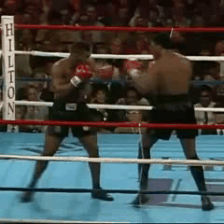

In [ ]:
test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])